# Replication of the do-file "hbs"

In [18]:
# housekeeping
import pandas as pd
import statsmodels.formula.api as sm
import statsmodels.tsa.api as smt
import numpy as np
import matplotlib.pyplot as plt

In [19]:
# read data in

df = pd.read_stata('data/data_hbs_20110196.dta')

df.head()

,hid,born_2005,born_2006,born_2007,born_2008,m_2005,m_2006,m_2007,m_2008,m2_2005,...,m_3rd_birth,s_3rd_birth,dup,n,month,sexk,post,month2,month3,n_month
0,9.0,1.0,0.0,0.0,0.0,5.0,NaN,NaN,NaN,5.0,...,NaN,NaN,0,1.0,-26.0,6.0,0.0,676.0,-17576.0,5.0
1,14.0,1.0,0.0,0.0,0.0,4.0,NaN,NaN,NaN,4.0,...,NaN,NaN,0,1.0,-27.0,1.0,0.0,729.0,-19683.0,4.0
2,22.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,3.0,NaN,...,NaN,NaN,0,1.0,8.0,6.0,1.0,64.0,512.0,3.0
3,72.0,0.0,0.0,1.0,0.0,NaN,NaN,10.0,NaN,NaN,...,NaN,NaN,0,1.0,3.0,6.0,1.0,9.0,27.0,10.0
4,75.0,0.0,1.0,0.0,0.0,NaN,8.0,NaN,NaN,NaN,...,NaN,NaN,0,1.0,-11.0,6.0,0.0,121.0,-1331.0,8.0


#### General preparation of the data set

In [20]:
##########################################
# age of mom and dad

df.loc[df['agemom'].isna(), 'agemom'] = 0
df.loc[df['agedad'].isna(), 'agedad'] = 0

#########################################
# mom or dad not present

df.loc[:,['nomom','nodad']] = 0

df.loc[df['agemom'] == 0, 'nomom'] = 1
df.loc[df['agedad'] == 0, 'nodad'] = 1

########################################
# education of mom and dad

df['sec1mom']=0
df['sec1dad']=0

df['sec2mom']=0
df['sec2dad']=0

df['unimom']=0
df['unidad']=0

df.loc[df['educmom'] == 3, 'sec1mom'] = 1
df.loc[df['educdad'] == 3, 'sec1dad'] = 1

df.loc[(df['educmom'] > 3) & (df['educmom']<7), 'sec2mom'] = 1
df.loc[(df['educdad'] > 3) & (df['educdad']<7), 'sec2dad'] = 1

df.loc[(df['educmom'] == 7) | (df['educmom'] == 8), 'unimom'] = 1
df.loc[(df['educdad'] == 7) | (df['educdad'] == 8), 'unidad'] = 1

###########################################
# immigrant

df['immig'] = 0
df.loc[(df['nacmom'] == 2) | (df['nacmom'] == 3), 'immig'] = 1

###########################################
# mom not married

df['smom'] = 0
df.loc[df['ecivmom'] != 2, 'smom'] = 1

###########################################
# siblings

df['sib'] = 0
df.loc[df['nmiem2']>1, 'sib'] = 1

###########################################
# age

df['age2'] = df.agemom * df.agemom
df['age3'] = df.agemom * df.agemom * df.agemom

###########################################
# daycare

df['daycare_bin'] = 0
df.loc[df['m_exp12312']>0 , 'daycare_bin'] = 1

Preparation done correctly?

In [21]:

df.loc[(df['month']>-10) & (df['month']<9), ['gastmon', 'c_m_exp', 'dur_exp', \
       'm_exp12312', 'post', 'month', 'agemom', 'sec1mom', 'sec2mom', 'unimom',\
       'immig', 'sib']].describe()

,gastmon,c_m_exp,dur_exp,m_exp12312,post,month,agemom,sec1mom,sec2mom,unimom,immig,sib
count,958.000000,958.000000,958.000000,958.000000,958.000000,958.000000,958.00000,958.00000,958.000000,958.000000,958.000000,958.000000
mean,30507.152344,4778.249512,5654.333496,305.793976,0.487474,-0.779749,32.52140,0.23382,0.325678,0.320459,0.164927,0.538622
std,17721.419922,4274.954102,8740.152344,848.094299,0.500102,5.056271,5.44813,0.42348,0.468873,0.466897,0.371308,0.498766
min,3784.887207,0.000000,0.000000,0.000000,0.000000,-9.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,19151.454102,1848.718567,878.381012,0.000000,0.000000,-5.000000,30.00000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,26144.551758,3561.400635,2276.193359,0.000000,0.000000,-1.000000,33.00000,0.00000,0.000000,0.000000,0.000000,1.000000
75%,37713.207031,6202.619507,5468.384644,0.219947,1.000000,3.000000,36.00000,0.00000,1.000000,1.000000,0.000000,1.000000
max,182173.078125,28744.369141,68090.976562,6570.810059,1.000000,8.000000,49.00000,1.00000,1.000000,1.000000,1.000000,1.000000


### Replicating Table 4:

In [22]:
# preparation of dummy variables and interaction terms:

df['post_month'] = df.post * df.month
df['post_month2'] = df.post * df.month2

df.mes_enc = df.mes_enc.astype(int)

I_mes_enc = pd.get_dummies(df['mes_enc'],drop_first=True, prefix='mes_enc')

df.drop('mes_enc',axis=1, inplace=True)

df = pd.concat([df,I_mes_enc], axis=1)


# outcome variables in logs:
df['ltotexp'] = np.nan
df.loc[df['gastmon']!=0, 'ltotexp'] = np.log(df.gastmon)
df['lcexp'] = np.nan
df.loc[df['c_m_exp']!=0, 'lcexp'] = np.log(df.c_m_exp)
df['ldurexp'] = np.nan
df.loc[df['dur_exp']!=0, 'ldurexp'] = np.log(df.dur_exp)


# time windows:
spec1 = df.loc[(df['month']>-10) & (df['month']<9)]
spec2 = df.loc[(df['month']>-7) & (df['month']<6)]
spec3 = df.loc[(df['month']>-5) & (df['month']<4)]
spec4 = df.loc[(df['month']>-4) & (df['month']<3)]
spec5_6 = df.loc[(df['month']>-3) & (df['month']<2)]
sepc7_8 = df


C:\Users\Marc\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log
C:\Users\Marc\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log


In [23]:
# regressions:

list_of_dep_vars = ["gastmon", "ltotexp", "c_m_exp", "lcexp", "dur_exp", "ldurexp"]

reg_spec1 = []
for dep_var in list_of_dep_vars:
    formula = dep_var + "~ post + month + month2 + nomom + agemom + age2 + age3 + sec1mom + sec2mom + unimom + immig + sib + post_month + post_month2 + mes_enc_2 + mes_enc_3 + mes_enc_4 + mes_enc_5 + mes_enc_6  + mes_enc_7 + mes_enc_8 + mes_enc_9 + mes_enc_10 + mes_enc_11 +  mes_enc_12"
    reg_spec1.append(sm.OLS.from_formula(formula, data = spec1).fit(cov_type='HC1'))


reg_spec2 = []
for dep_var in list_of_dep_vars:
    formula = dep_var + "~ post + month + nomom + agemom + age2 + age3 + sec1mom + sec2mom + unimom + immig + sib + post_month + mes_enc_2 + mes_enc_3 + mes_enc_4 + mes_enc_5 + mes_enc_6  + mes_enc_7 + mes_enc_8 + mes_enc_9 + mes_enc_10 + mes_enc_11 +  mes_enc_12"
    reg_spec2.append(sm.OLS.from_formula(formula, data = spec2).fit(cov_type='HC1'))


In [24]:
# printing outputs:

print('\u2014'*40)
print('{:<8s}{:>11s}{:>12s}'.format("", "RDD 9m", "RDD 6m"))
print('\u2014'*40)
x=0
while x < len(list_of_dep_vars):
    print('{:<8s}{:>12.3f}{:>12.3f}'.format(list_of_dep_vars[x], reg_spec1[x].params.post, reg_spec2[x].params.post))
    print('{:<8s}{:>12.3f}{:>12.3f}'.format("", reg_spec1[x].bse.post, reg_spec2[x].bse.post))
    x += 1

————————————————————————————————————————
             RDD 9m      RDD 6m
————————————————————————————————————————
gastmon    -3175.158   -2247.452
            2838.302    2244.167
ltotexp       -0.142      -0.105
               0.092       0.074
c_m_exp     -406.931    -599.337
             765.670     617.533
lcexp         -0.011      -0.034
               0.195       0.151
dur_exp    -1513.256   -1849.083
            1688.123    1344.743
ldurexp        0.157       0.025
               0.297       0.239


C:\Users\Marc\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


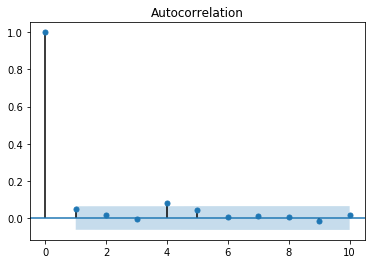

In [25]:
# keep in mind: autocorrelation!

acf1 = smt.graphics.plot_acf(reg_spec1[0].resid,lags=10,alpha=0.05)
acf1.show()
